## 2 Equivariant neural networks
### (c)
#### 1.

In [1]:
import torch
from e3nn.o3 import wigner_D

# Define a rotation: use YXY Euler angles (alpha, beta, gamma) (YXY seems to be the order of rotations) (values arbitratily chosen)
alpha = torch.tensor(0.1)  # Rotation around Y-axis
beta = torch.tensor(0.2)   # Rotation around X-axis
gamma =torch.tensor(0.3)  # Rotation around Y-axis

D_matrix = wigner_D(1, alpha, beta, gamma)

print("Wigner-D Matrix for l=1 (rotation matrix):")
print(D_matrix)

# Verify equivalence to a standard 3D rotation matrix
from scipy.spatial.transform import Rotation as R
rotation_matrix = R.from_euler('YXY', [alpha,beta,gamma]).as_matrix()

print("\nStandard 3D Rotation Matrix:")
print(rotation_matrix)


print("\nDifference between Wigner-D and 3D Rotation Matrix:")
print(D_matrix.numpy() - rotation_matrix)


assert torch.allclose(torch.tensor(rotation_matrix,dtype=torch.float), D_matrix, atol=1e-6)
print("Verified: Wigner-D matrix matches the Scipy rotation matrix.")

Wigner-D Matrix for l=1 (rotation matrix):
tensor([[ 0.9216,  0.0198,  0.3875],
        [ 0.0587,  0.9801, -0.1898],
        [-0.3836,  0.1977,  0.9021]])

Standard 3D Rotation Matrix:
[[ 0.92164908  0.01983384  0.38751721]
 [ 0.0587108   0.98006658 -0.18979606]
 [-0.38355705  0.19767681  0.902113  ]]

Difference between Wigner-D and 3D Rotation Matrix:
[[ 3.75588739e-07 -3.17601971e-08 -1.96742878e-06]
 [-4.79310225e-07  2.02125393e-08  2.26262875e-07]
 [ 1.94006552e-06 -2.75109682e-07  4.38595927e-07]]
Verified: Wigner-D matrix matches the Scipy rotation matrix.


For l=1 the wigner-d matrix corrspons to the rotation matrix. Therefore l=1 is the vecor representation.

#### 2.

In [2]:
for l in [2, 3, 4]:
    D_matrix = wigner_D(l, alpha, beta, gamma)
    print(f"Wigner-D matrix for l = {l} has shape: {D_matrix.shape}")
    assert D_matrix.shape == (2 * l + 1, 2 * l + 1), "Dimension mismatch!"

Wigner-D matrix for l = 2 has shape: torch.Size([5, 5])
Wigner-D matrix for l = 3 has shape: torch.Size([7, 7])
Wigner-D matrix for l = 4 has shape: torch.Size([9, 9])


The Shapes of the wigner-d matrixces corrsponds to the expectations.

#### 3.
For equivariance proof show:
$$
Y_l(R \cdot \mathbf{r}) = D_l(R) \cdot Y_l(\mathbf{r})
$$

In [3]:
from scipy.special import sph_harm
import numpy as np

def transform_angles_yxy(theta, phi, alpha, beta, gamma):
    """
    Transform the angular components of spherical coordinates (theta, phi)
    using Euler angles (alpha, beta, gamma) in the YXY convention while keeping the radius unaffected.
    
    Parameters:
    - theta: Polar angle (colatitude in radians)
    - phi: Azimuthal angle (longitude in radians)
    - alpha: First Euler angle (rotation around Y-axis)
    - beta: Second Euler angle (rotation around X-axis)
    - gamma: Third Euler angle (rotation around Y-axis)
    
    Returns:
    - theta_new: Transformed polar angle
    - phi_new: Transformed azimuthal angle
    """
    
    # Rotation matrices for the YXY Euler angle convention:
    Ry_alpha = np.array([
        [np.cos(alpha), 0, np.sin(alpha)],
        [0, 1, 0],
        [-np.sin(alpha), 0, np.cos(alpha)]
    ])
    
    Rx_beta = np.array([
        [1, 0, 0],
        [0, np.cos(beta), -np.sin(beta)],
        [0, np.sin(beta), np.cos(beta)]
    ])
    
    Ry_gamma = np.array([
        [np.cos(gamma), 0, np.sin(gamma)],
        [0, 1, 0],
        [-np.sin(gamma), 0, np.cos(gamma)]
    ])
    
    # Overall rotation matrix (YXY convention)
    R = np.dot(Ry_gamma, np.dot(Rx_beta, Ry_alpha))
    
    # Convert spherical coordinates (theta, phi) to Cartesian coordinates (x, y, z)
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    
    # Apply the rotation to the Cartesian coordinates
    xyz_new = np.dot(R, np.array([x, y, z]))
    
    # Convert the rotated Cartesian coordinates back to spherical coordinates
    theta_new = np.arccos(xyz_new[2])  # Polar angle
    phi_new = np.arctan2(xyz_new[1], xyz_new[0])  # Azimuthal angle
    
    return theta_new, phi_new


def compute_spherical_harmonics(l, theta, phi):
    """Compute all spherical harmonics Y_lm for a given l at (theta, phi)."""
    Y = []
    for m in range(-l, l + 1):
        Y_lm = sph_harm(m, l, phi, theta)
        Y.append(Y_lm)
    return torch.tensor(Y, dtype=torch.complex64)

for l in [1, 2, 3, 4]:
    theta, phi = np.pi / 3, np.pi / 4  # Example spherical coordinates arbitraily chosen
    alpha, beta, gamma = torch.tensor([0.1, 0.2, 0.3])  # Rotation angles in radians arbitrarily chosen

    Y_l = compute_spherical_harmonics(l, theta, phi)

    theta_new, phi_new = transform_angles_yxy(theta, phi, alpha, beta, gamma)

    Y_l_rotated = compute_spherical_harmonics(l, theta_new, phi_new)

    D_l = torch.tensor(wigner_D(l, alpha, beta, gamma), dtype=torch.complex64)

    Y_l_transformed = D_l @ Y_l

    # Check if equivariance holds: Y_l(R * r) == D_l(R) * Y_l(r)
    assert torch.allclose(Y_l_rotated, Y_l_transformed, atol=1e-5), f"Equivariance failed for l = {l}"
    print(f"Equivariance verified for l = {l}")

/var/folders/f4/8n1xlsxx5159pp44m83ldz5w0000gn/T/ipykernel_38131/1467973469.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D_l = torch.tensor(wigner_D(l, alpha, beta, gamma), dtype=torch.complex64)


AssertionError: Equivariance failed for l = 1

The Equivariance is not confirmed. Most likely there is a mistake in the code, which could not be found. I would be thankful if the Tutor recognises the mistake.

#### 4.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

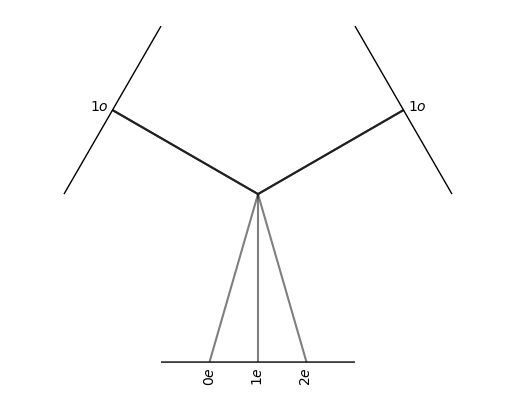

In [4]:
from e3nn.o3 import Irreps
import e3nn


l1 = Irreps("1x1o") 
l2 = Irreps("1x1o")

tensor_product = e3nn.o3.FullTensorProduct(l1, l2)
tensor_product.visualize()

According to equation 3 the resulting diensions are 1, 3 and 5 with l=1, 2 and 5.

#### 5.

In [5]:
v = np.array([1, 2, 3]) 
w = np.array([4, 5, 6])
rotation = R.random()  # This generates a random rotation object

tensor_product = np.outer(v, w)
print("Tensor product of v and w (outer product) and rotation:")
print(np.dot(rotation.as_matrix(), np.dot(tensor_product, rotation.as_matrix().T)))

v_rotated = rotation.apply(v)
w_rotated = rotation.apply(w)

tensor_product_rotated = np.outer(v_rotated, w_rotated)
print("\nTensor product after of rotated vectors:")
print(tensor_product_rotated)

equivariance_check = np.allclose(tensor_product_rotated, np.dot(rotation.as_matrix(), np.dot(tensor_product, rotation.as_matrix().T)))
print("\nEquivariance check result:", equivariance_check)

Tensor product of v and w (outer product) and rotation:
[[ 2.11504475e-01  1.33095101e-02 -1.06349922e+00]
 [ 1.08030554e+00  6.79812444e-02 -5.43205572e+00]
 [-6.30844914e+00 -3.96976789e-01  3.17205143e+01]]

Tensor product after of rotated vectors:
[[ 2.11504475e-01  1.33095101e-02 -1.06349922e+00]
 [ 1.08030554e+00  6.79812444e-02 -5.43205572e+00]
 [-6.30844914e+00 -3.96976789e-01  3.17205143e+01]]

Equivariance check result: True


Applying the rotation before or after the outer product gives an equivariant result.

#### 6.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

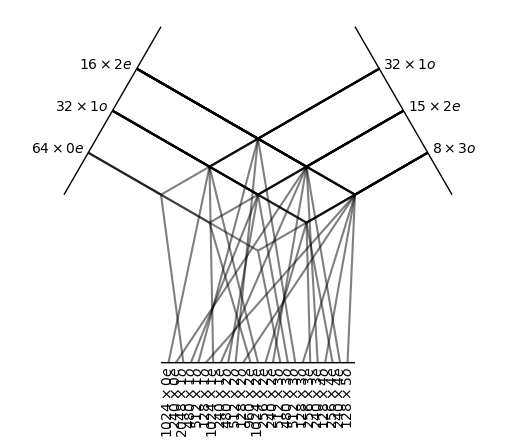

In [6]:
rep1 = Irreps("64x0e + 32x1o + 16x2e")
rep2 = Irreps("32x1o + 15x2e + 8x3o")
tensor_product = e3nn.o3.FullTensorProduct(rep1, rep2)
tensor_product.visualize()

In [13]:
import re
import pandas as pd

def parse_irrep_string(irrep_str):
    """
    Parse the input string of irreps into a list of tuples representing 
    the multiplicity and angular momentum (l) for each irrep.
    
    Example input: '64x0e + 32x1o + 16x2e'
    
    Returns:
    - List of tuples: [(64, 0, 'e'), (32, 1, 'o'), (16, 2, 'e')]
    """
    irrep_pattern = r'(\d+)x(\d+)([eo])'
    matches = re.findall(irrep_pattern, irrep_str)
    parsed_irreps = [(int(m[0]), int(m[1]), m[2]) for m in matches]
    return parsed_irreps


def calculate_tensor_product_from_irreps(irrep_str1, irrep_str2):
    """
    Calculate the tensor product between two input string representations of irreps
    and return the resulting dimensions in the same format as the input string.
    
    Args:
    - irrep_str1: The first string representing a direct sum of irreps (e.g., '64x0e + 32x1o + 16x2e')
    - irrep_str2: The second string representing a direct sum of irreps
    
    Returns:
    - result_str: String of the resulting irreps in the same format as the input
    """
    # Parse the irreps from the input strings
    irreps1 = parse_irrep_string(irrep_str1)
    irreps2 = parse_irrep_string(irrep_str2)
    
    result_irreps = []

    # For each combination of irreps from the two input representations
    for mult1, l1, parity1 in irreps1:
        for mult2, l2, parity2 in irreps2:
            # Calculate the tensor product of the two irreps with angular momenta l1 and l2
            result_dimensions= calculate_tensor_product_dimensions(l1, l2)
            
            # Multiply the multiplicities from both irreps
            for l in result_dimensions:
                parity = 'o' if l%2 else 'e'
                result_irreps.append([mult1 * mult2, l, parity])

    # Convert the result list to a string format
    result_str = ' + '.join([f"{mult}x{l}{parity}" for mult, l, parity in result_irreps])
    
    return result_str


def calculate_tensor_product_dimensions(l1, l2):
    """
    Calculate the dimensions of the resulting irreps when taking the tensor product
    of two irreps with angular momenta l1 and l2.
    
    Parameters:
    - l1: The angular momentum quantum number of the first irrep
    - l2: The angular momentum quantum number of the second irrep
    
    Returns:
    - result_dimensions: List of the dimensions of the resulting irreps
    """
    result_dimensions = []
    for L in range(abs(l1 - l2), l1 + l2 + 1):
        result_dimensions.append(L)
    
    return result_dimensions


# Example usage
irrep_str1 = '64x0e + 32x1o + 16x2e'  # First representation
irrep_str2 = '32x1o + 16x2e + 8x3o'  # Second representation

result_str = calculate_tensor_product_from_irreps(irrep_str1, irrep_str2)

print(f"Resulting tensor product: {result_str}")

Resulting tensor product: 2048x1o + 1024x2e + 512x3o + 1024x0e + 1024x1o + 1024x2e + 512x1o + 512x2e + 512x3o + 256x2e + 256x3o + 256x4e + 512x1o + 512x2e + 512x3o + 256x0e + 256x1o + 256x2e + 256x3o + 256x4e + 128x1o + 128x2e + 128x3o + 128x4e + 128x5o


The output should be equal to the one of the figure.